In [ ]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def interpolate(xp, yp, x):
    """
    Interpolates the voltage values for given SOC values.
    """
    f = interp1d(
        xp, yp,
        kind='linear',
        fill_value="extrapolate",   # allow linear extrapolation
        assume_sorted=False         # will sort xp/yp internally
    )
    return f(x)


class CellOCVReconstruction:
    """
    Reconstructs full-cell OCV from two PyBaMM OCV functions and their N:P ratio.
    Provides methods to compute stoichiometries and voltage curves.
    """
    def __init__(self, cath_ocv_func, an_ocv_func, np_ratio: float,
                 v_min=2.5, v_max=4.2, formation_loss_an=0.0, formation_loss_ca=0.0):
        self.cath = cath_ocv_func    # PyBaMM OCV: soc -> V
        self.an = an_ocv_func        # PyBaMM OCV: soc -> V
        self.np_ratio = np_ratio
        # formation losses (fraction) can be provided
        self.np_offset = np_ratio * formation_loss_an - formation_loss_ca
        self.v_min = v_min
        self.v_max = v_max

    def align_anode_cathode(self, sol_cath, np_ratio=None, np_offset=None):
        """
        Compute anode stoichiometry from cathode stoichiometry based on N:P ratio and offset.
        """
        if np_ratio is None:
            np_ratio = self.np_ratio
        if np_offset is None:
            np_offset = self.np_offset
        return (-sol_cath + 1 - np_offset) / np_ratio

    def reconstruct_voltage(self, an0, cath0, an1, cath1,
                            direction='charge',
                            soc_vec=None):
        """
        Reconstruct full-cell and half-cell voltages along a SOC vector.
        Returns:
          V_cell, V_cath, V_an, soc_an, soc_cath
        """
        if soc_vec is None:
            soc_vec = np.linspace(0, 1, 100)
        soc_an = an0 + (an1 - an0) * soc_vec
        soc_cath = cath0 + (cath1 - cath0) * soc_vec
        V_cath = self.cath(soc_cath)
        V_an = self.an(soc_an)
        V_cell = V_cath - V_an
        return V_cell, V_cath, V_an, soc_an, soc_cath

    def get_stoichiometries(self, np_ratio=None, np_offset=None,
                            v_min=None, v_max=None):
        """
        Compute the anode/cathode stoichiometries at cell cutoff voltages.
        Returns: an0, cath0, an1, cath1
        """
        if v_min is None:
            v_min = self.v_min
        if v_max is None:
            v_max = self.v_max
        if np_ratio is None:
            np_ratio = self.np_ratio
        if np_offset is None:
            np_offset = self.np_offset
        an0 = self.align_anode_cathode(1, np_ratio, np_offset)
        an1 = self.align_anode_cathode(0, np_ratio, np_offset)
        cath0 = 1.0
        cath1 = 0.0
        grid = np.linspace(0,1, 200)
        vc_dis, _, _, _, _ = self.reconstruct_voltage(an0, cath0, an1, cath1, 'charge', grid)
        vc_cha, _, _, _, _ = self.reconstruct_voltage(an0, cath0, an1, cath1, 'charge', grid)
        soc0_cut = interpolate(vc_dis, grid, v_min)
        soc1_cut = interpolate(vc_cha, grid, v_max)
        an0_cut = soc0_cut*(an1-an0)+an0
        an1_cut = soc1_cut*(an1-an0)+an0
        cath0_cut = soc0_cut*(cath1-cath0)+cath0
        cath1_cut = soc1_cut*(cath1-cath0)+cath0
        return an0_cut, cath0_cut, an1_cut, cath1_cut

    def simulate_aging_modes(self, lampe, lamne, lli):
        """
        Compute aged stoichiometries given aging fractions.
        Returns: an0, cath0, an1, cath1 for aged state.
        """
        np_aged = self.np_ratio * (1 - lamne) / (1 - lampe)
        np_offset_aged = 1 - (1 - self.np_offset) * (1 - lli) / (1 - lampe)
        return self.get_stoichiometries(np_ratio=np_aged, np_offset=np_offset_aged)


class BatteryTankPlotter:
    """
    Uses CellOCVReconstruction to plot dQ/dV 'tanks' and OCV curves for BOL and aged cells.
    """
    def __init__(self, reconstructor: CellOCVReconstruction, resolution=500):
        self.rec = reconstructor
        self.resolution = resolution
        self.bc = {
            'an_bol': '#333333',
            'ca_bol': '#5DADE2',
            'an_aged': '#444444',
            'ca_aged': '#003B73',
            'fill_bol': '#44546A',
            'fill_aged': '#70AD47',
            'delta': '#F39C12'
        }

    def _compute_electrode_curves(self, an0, cath0, an1, cath1, direction):
        soc = np.linspace(1,0, self.resolution)
        V_cell, V_ca, V_an, sol_an, sol_ca = self.rec.reconstruct_voltage(
            an0, cath0, an1, cath1, direction, soc)
        dQdV_an = 1 / np.gradient(V_an, sol_an)
        dQdV_ca = 1 / np.gradient(V_ca, sol_ca)
        return soc, sol_an, V_an, dQdV_an, sol_ca, V_ca, dQdV_ca, V_cell

    def plot(self, soc=0.5, lampe=0.0, lamne=0.0, lli=0.0):
        ## Full curves
        soc_vec = np.linspace(0,1,self.resolution)
        V_an = self.rec.an(soc_vec)
        V_cath = self.rec.cath(soc_vec)
        dQdV_an = 1 / np.gradient(V_an, soc_vec)
        dQdV_ca = 1 / np.gradient(V_cath, soc_vec)
        
        # plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ## Plot the full curves BOL
        bc = self.bc
        ax1.plot(dQdV_an*self.rec.np_ratio, -V_an, color=bc['an_aged'],linestyle='--')
        ax1.plot(-dQdV_an*self.rec.np_ratio, -V_an, color=bc['an_aged'],linestyle='--')
        ax1.plot(dQdV_ca, -V_cath, color=bc['ca_aged'],linestyle='--')
        ax1.plot(-dQdV_ca, -V_cath, color=bc['ca_aged'],linestyle='--')

        ## Plot the full curves aged
        ax1.plot(dQdV_an*self.rec.np_ratio*(1-lamne), -V_an, color=bc['an_aged'], label='Anode aged')
        ax1.plot(-dQdV_an*self.rec.np_ratio*(1-lamne), -V_an, color=bc['an_aged'])
        ax1.plot(dQdV_ca*(1-lampe), -V_cath, color=bc['ca_aged'], label='Cathode aged')
        ax1.plot(-dQdV_ca*(1-lampe), -V_cath, color=bc['ca_aged'])

        # Compute aged filling
        # BOL stoichiometries
        an0_bol,cath0_bol,an1_bol,cath1_bol = self.rec.get_stoichiometries()
        # aged stoichiometries
        an0_a, ca0_a, an1_a, ca1_a = self.rec.simulate_aging_modes(lampe, lamne, lli)
        # get aged voltages
        v_an0 = self.rec.an(an0_a)
        v_an1 = self.rec.an(an1_a)
        v_ca1 = self.rec.cath(ca1_a)
        v_ca0 = self.rec.cath(ca0_a)
        # curves
        ax1.axhline(y=-v_an0, color=self.bc["an_bol"], linestyle=":", linewidth=1)
        ax1.axhline(y=-v_an1, color=self.bc["an_bol"], linestyle=":", linewidth=1)
        ax1.axhline(y=-v_ca0, color=self.bc["an_bol"], linestyle=":", linewidth=1)
        ax1.axhline(y=-v_ca1, color=self.bc["an_bol"], linestyle=":", linewidth=1)

        # Reconstruct cell voltage
        V_cell, V_ca, V_an, sol_an, sol_ca = self.rec.reconstruct_voltage(
            an0_a, ca0_a, an1_a, ca1_a, "charge",soc_vec)
        
        ax2.plot(soc_vec,V_cell)

        # (soc_full, sa_b, Va_b, dQa_b, sc_b, Vc_b, dQc_b, Vcell_b) = self._compute_electrode_curves(
        #     0, 1, 1, 0, 'charge')

        

        # aged tanks fill
        # mask_a = soc_full <= soc
        # Determine voltage for soc
        sol_an_cur = an0_a+(an1_a-an0_a)*(soc)
        sol_ca_cur = ca0_a+(ca1_a-ca0_a)*(soc)
        sol_an_vec = np.linspace(0,sol_an_cur,100)
        sol_ca_vec = np.linspace(sol_ca_cur,1,100)
        V_an_cur = self.rec.an(np.linspace(0,sol_an_cur,100))
        V_ca_cur = self.rec.cath(np.linspace(0,sol_ca_cur,100))
        dQ_an_cur = interpolate(soc_vec,dQdV_an,sol_an_vec)
        dQ_cath_cur = interpolate(soc_vec,dQdV_ca,sol_ca_vec)
        ax1.fill_betweenx(-V_an_cur, -dQ_an_cur*self.rec.np_ratio*(1-lamne), dQ_an_cur*self.rec.np_ratio*(1-lamne), color=bc['fill_aged'], alpha=0.5)
        ax1.fill_betweenx(-V_ca_cur, -dQ_cath_cur*(1-lampe), dQ_cath_cur*(1-lampe), color=bc['fill_aged'], alpha=0.5)
        # # delta V arrow
        # dV = Vcell_b[int(soc*self.resolution)] - Vcell_b[0]
        # ax1.annotate('', xy=(0, Vcell_b[int(soc*self.resolution)]), xytext=(0, Vcell_b[0]),
        #              arrowprops=dict(arrowstyle='<->', color=bc['delta'], lw=2))
        # ymid = -0.5*(Vcell_b[int(soc*self.resolution)] + Vcell_b[0])
        # ax1.text(0.1, ymid, f'ΔV={dV:.3f} V', color=bc['delta'])
        ax1.set_xlabel('dQ/dV [Ah/V]')
        ax1.set_ylabel('Voltage [V]')
        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-5, 0)
        yticks = np.arange(-5, 1, 1)
        ax1.set_yticks(yticks)
        ax1.legend(loc='upper left')
        ax1.grid(True)
        # # OCV curves increasing        
        (soc_full, sa_b, Va_b, dQa_b, sc_b, Vc_b, dQc_b, Vcell_b) = self._compute_electrode_curves(
           an0_bol, cath0_bol, an1_bol, cath1_bol, 'charge')
        (soc_full, sa_a, Va_a, dQa_a, sc_a, Vc_a, dQc_a, Vcell_a) = self._compute_electrode_curves(
            an0_a, ca0_a, an1_a, ca1_a, 'charge')
        ax2.plot(soc_full, Vcell_b, color=bc['an_bol'], label='Cell BOL')
        ax2.plot(soc_full, Vcell_a, color=bc['ca_aged'], label='Cell aged')
        ax2.set_xlabel('SOC')
        ax2.set_ylabel('Voltage [V]')
        ax2.legend()
        ax2.grid(True)
        ax2.set_xlim(0,1)
        plt.tight_layout()
        plt.show()

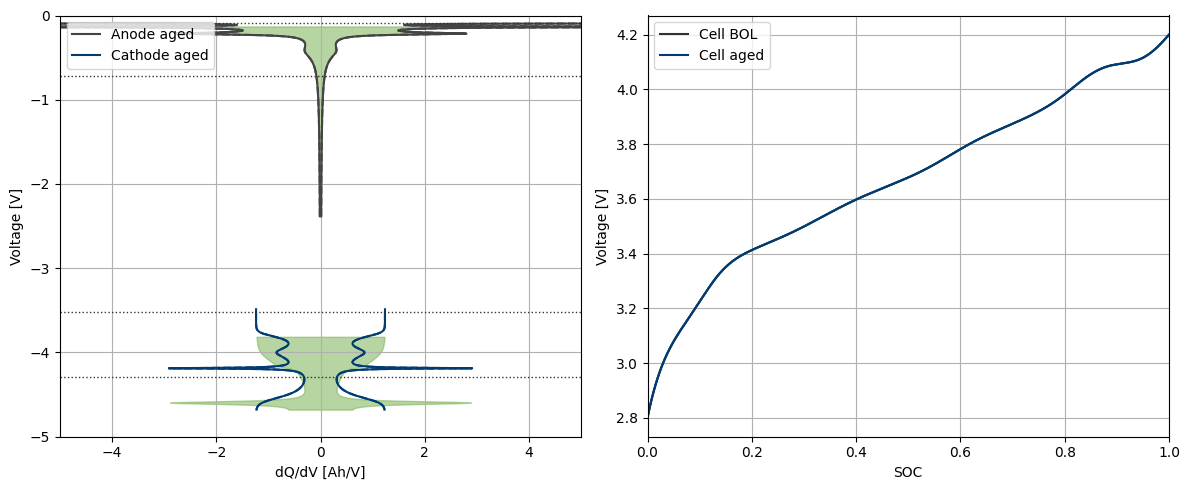

In [43]:
import pybamm

# 1) Lade die OCV-Funktionen aus PyBaMM
param = pybamm.ParameterValues("Chen2020")
ocv_anode   = param["Negative electrode OCP [V]"]  
ocv_cathode = param["Positive electrode OCP [V]"]  

# 2) Definiere N:P‑Ratio und Spannungsgrenzen
np_ratio = 1
v_min = 2.8
v_max = 4.2

# 3) Erzeuge das Reconstruct‑Objekt
cell_rec = CellOCVReconstruction(
    cath_ocv_func=ocv_cathode,
    an_ocv_func=ocv_anode,
    np_ratio=np_ratio,
    v_min=v_min,
    v_max=v_max,
    formation_loss_an=0.0,
    formation_loss_ca=0.0
)

# 4) Erzeuge den Plotter
plotter = BatteryTankPlotter(cell_rec, resolution=500)

# 5) Erstelle den Plot für SOC=0.5 und beispielhafte Alterungs‑Parameter
plotter.plot(
    soc=0.5,
    lampe=0,   # cathode loss fraction
    lamne=0,   # anode loss fraction
    lli=0    # LLI fraction
)
